In [2]:

import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDClassifier


# Clara
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline 

Data ingestion and cleaning

In [3]:
df= pd.read_csv("project_adult.csv")
df_val = pd.read_csv("project_validation_inputs.csv")

In [4]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [5]:
df_val.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


In [6]:

# Identifying missing values 
cols_with_question_mark = df.columns[df.isin(['?']).any()]
print("Columns with '?' values:")
print(cols_with_question_mark)


Columns with '?' values:
Index(['workclass', 'occupation', 'native-country'], dtype='object')


In [7]:
question_mark_counts = (df == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         1447
occupation        1454
native-country     458
dtype: int64


In [8]:
cols_with_question_mark = df_val.columns[df_val.isin(['?']).any()]
question_mark_counts = (df_val == '?').sum()
print("\nColumns with at least one '?' value:")
print(question_mark_counts[question_mark_counts > 0])


Columns with at least one '?' value:
workclass         389
occupation        389
native-country    125
dtype: int64


Imputing missing values with the mode and Scaling data

In [9]:

# Replace '?' with NaN
df = df.replace('?', np.nan)

df_val = df_val.replace('?', np.nan)

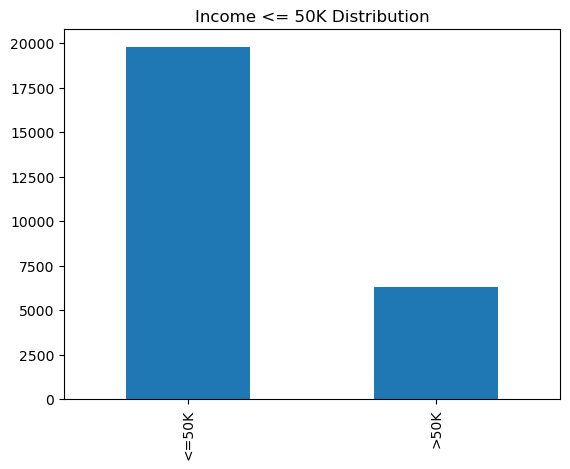

In [10]:
df['income'].value_counts().plot(kind='bar')
plt.title('Income <= 50K Distribution')
plt.show()


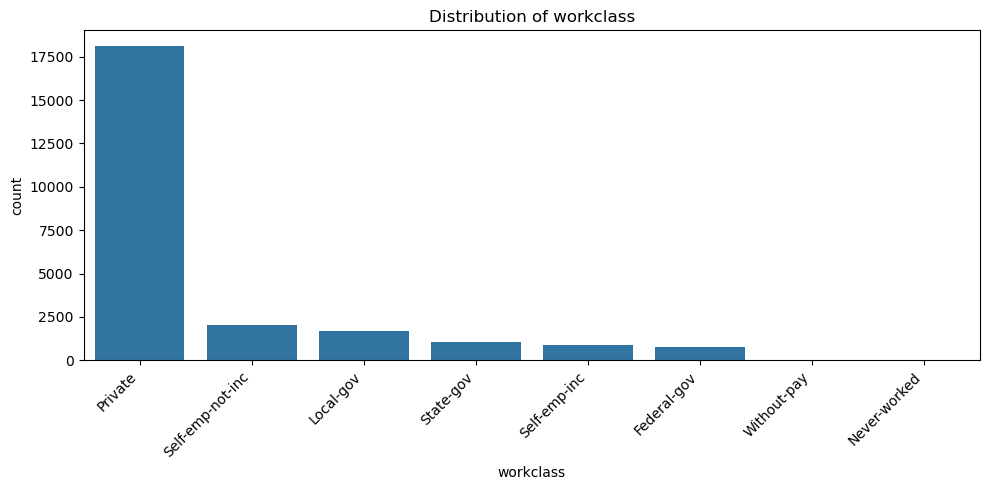

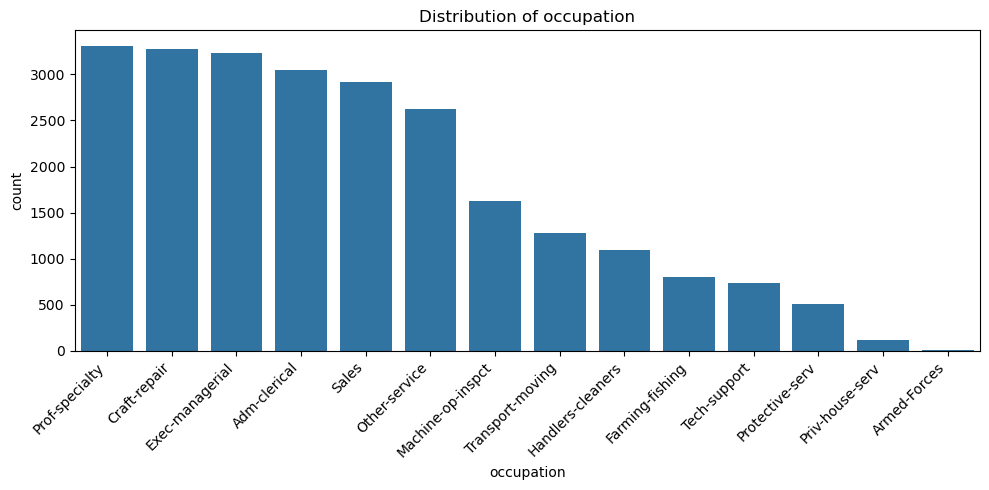

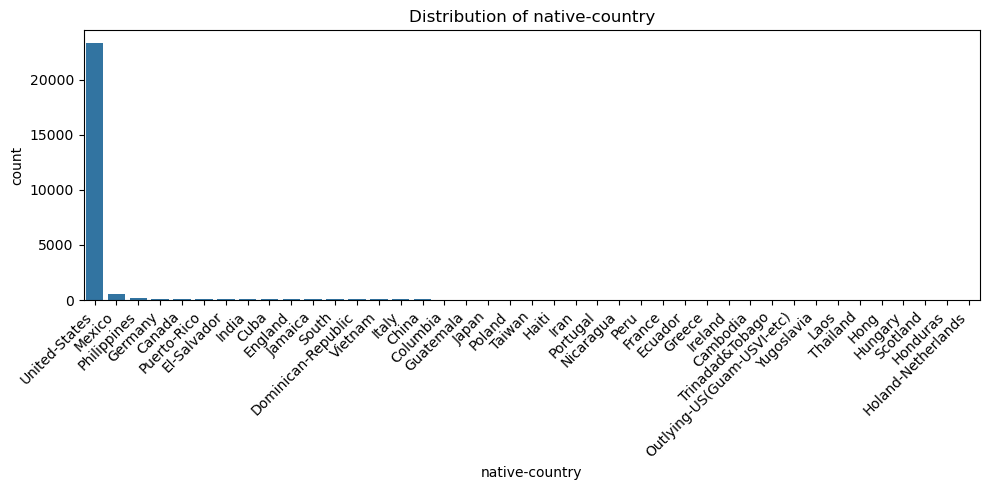

In [11]:


# Ploting distributions for columns with missing values
cols_to_plot = ['workclass', 'occupation', 'native-country']

for col in cols_to_plot:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [12]:
#Impute missing values in each column with its mode
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])
for col in df_val.columns:
    df_val[col] = df_val[col].fillna(df_val[col].mode()[0])

In [13]:
# Encoding and spliting data

TEST_SIZE   = 0.20
RANDOM_SEED = 35

categorical_cols = ['workclass','education','marital-status','occupation',
                    'relationship','race','sex','native-country']
numerical_cols   = ['age','fnlwgt','education-num','capital-gain',
                    'capital-loss','hours-per-week']

# clean column names
df.columns = (df.columns.str.strip()
                        .str.lower()
                        .str.replace(r'\s+', '-', regex=True))

df = pd.get_dummies(df, columns=[c for c in categorical_cols if c in df.columns],
                    drop_first=True)

# split features and target
X = df.drop(columns=['income'])
y = df['income'].map({">50K": 1, "<=50K": 0})

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# Scale numeric columns
scaler = StandardScaler()
X_train_df[numerical_cols] = scaler.fit_transform(X_train_df[numerical_cols])
X_test_df[numerical_cols]  = scaler.transform(X_test_df[numerical_cols])

# Convert to NumPy
X_train = X_train_df.to_numpy(dtype=np.float64)
X_test  = X_test_df.to_numpy(dtype=np.float64)
y_train = y_train.to_numpy(dtype=np.int64)
y_test  = y_test.to_numpy(dtype=np.int64)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (20838, 98), X_test: (5210, 98)
y_train: (20838,), y_test: (5210,)


Perceptron Model

Hard coded version

In [14]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [15]:
#model training 
ppn = Perceptron(eta=.01, n_iter=100, random_state=1)
ppn.fit(X_train, y_train)

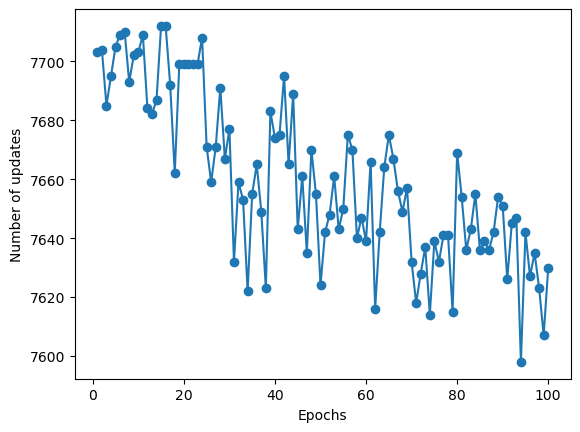

In [16]:
# Plot miscalssificaiotn error for each epoch
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

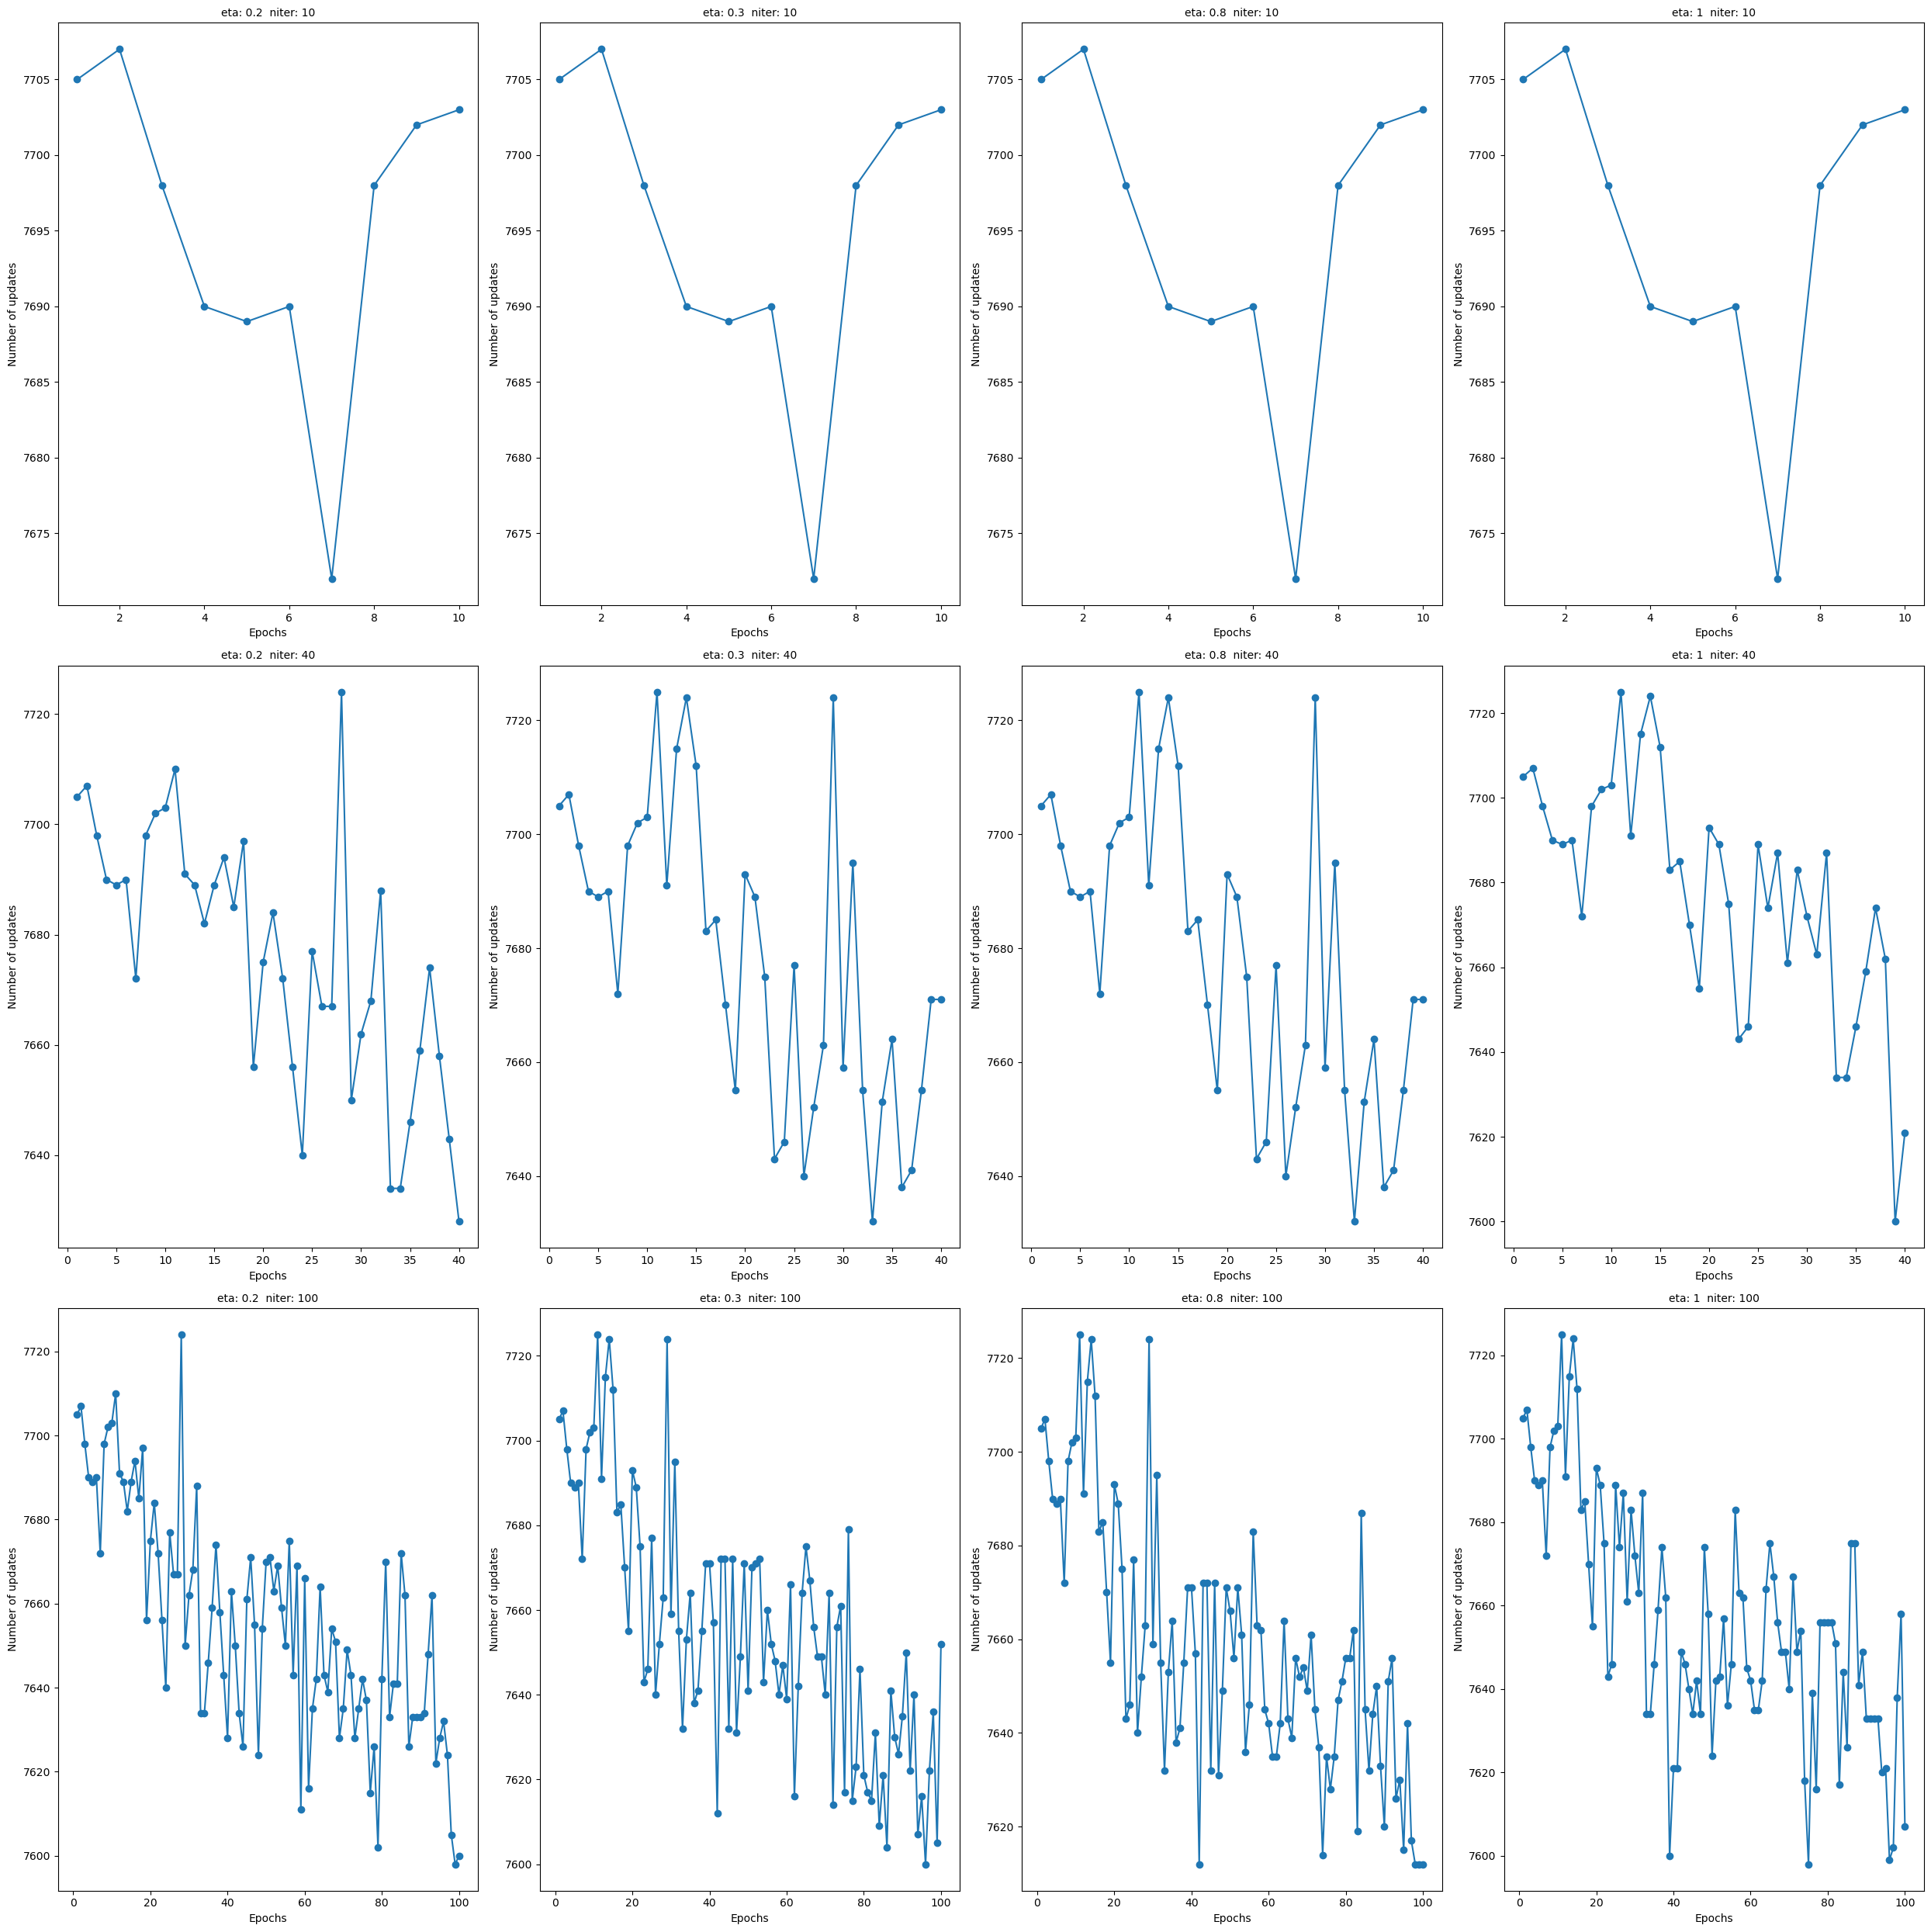

In [17]:
# Train Perceptron and find good value of eta and n_iter
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(25, 25))

list_eta = [0.2, 0.3, 0.8, 1]
list_niter = [10, 40, 100]

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(n_iter=n_temp, eta= e_temp).fit(X_train, y_train)
        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Number of updates', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)
    
plt.tight_layout()
plt.show()

In [18]:
# prediction accuracy 
train_preds = ppn.predict(X_train)
test_preds  = ppn.predict(X_test)

train_acc = (train_preds == y_train).mean()
test_acc  = (test_preds == y_test).mean()

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy:  {test_acc:.3f}")

Train accuracy: 0.759
Test accuracy:  0.760


In [19]:
#Scikit Learn version
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report

# Initialize model
ppn = Perceptron(
    penalty=None,      
    alpha=0.0001,      
    max_iter=1000,     # number of epochs 
    eta0=1.0,          
    random_state=42,
    tol=1e-3           
)
# Train model
ppn.fit(X_train, y_train)

# Predictions
y_pred = ppn.predict(X_test)

# Evaluation
print("Train accuracy:", accuracy_score(y_train, ppn.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Train accuracy: 0.7591899414531145
Test accuracy: 0.7591170825335892


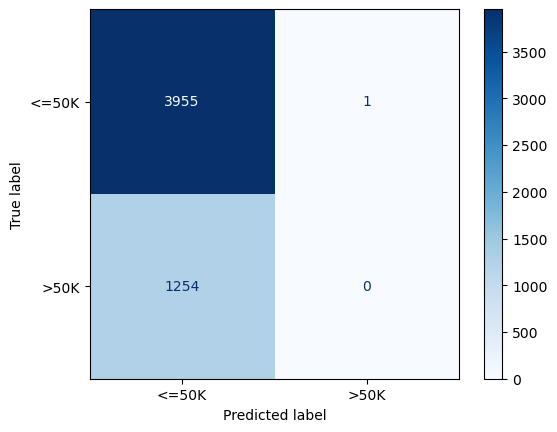

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = ppn.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap="Blues")
plt.show()

Adaline Model

In [21]:
#In class implementation of Adaline with SGD
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    # def _update_weights(self, xi, target):
    #     """Apply Adaline learning rule to update the weights"""
    #     output = self.activation(self.net_input(xi))
    #     error = (target - output)
    #     self.w_ += self.eta * 2.0 * xi * (error)
    #     self.b_ += self.eta * 2.0 * error
    #     loss = error**2
    #     return loss
    
    # ----Updated version with gradient clipping to handel one hot encoded data----
    def _update_weights(self, xi, target):
      output = self.activation(self.net_input(xi))
      error = (target - output)
      
      # Gradient computation
      grad_w = 2.0 * xi * error
      grad_b = 2.0 * error
      
      # Clip gradients to prevent explosion
      grad_w = np.clip(grad_w, -1, 1)
      grad_b = np.clip(grad_b, -1, 1)
      
      # Update weights
      self.w_ += self.eta * grad_w
      self.b_ += self.eta * grad_b
      
      # Return squared error
      return error**2
 
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [22]:
#Train model 
ada = AdalineSGD(eta=.001, n_iter=100, random_state=1)
ada.fit(X_train, y_train)  


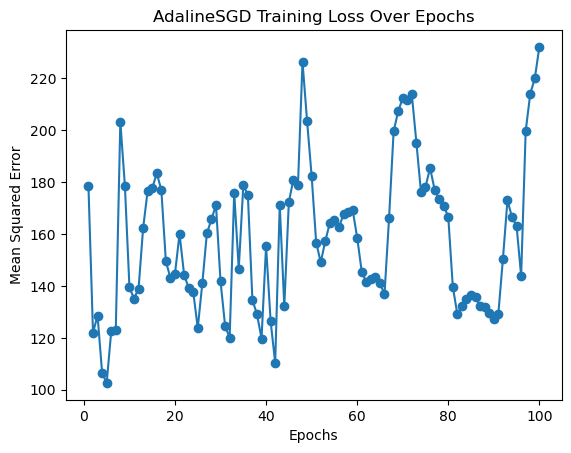

In [23]:
plt.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('AdalineSGD Training Loss Over Epochs')
plt.show()



In [24]:
y_train_pred = ada.predict(X_train)
train_accuracy = np.mean(y_train_pred == y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


Training Accuracy: 24.72%


In [25]:
#Scikit-learn version of Adaline using SGDClassifier
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Scikit-learn Adaline (SGDClassifier) accuracy: 0.7591


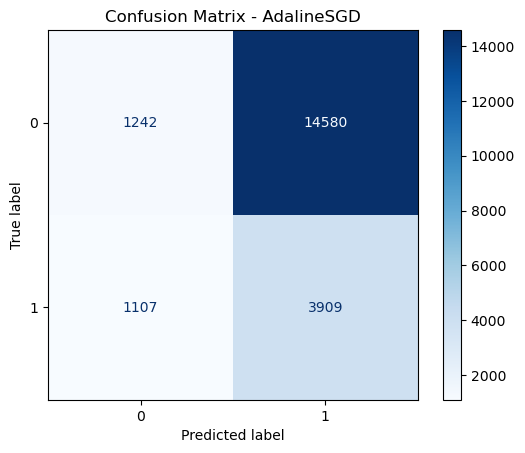

In [26]:
y_train_pred = ada.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - AdalineSGD")
plt.show()



In [27]:
# Clara
# Implemetation of Scikit-Learn to train a Logistic Regression Model

# The idea of a balanced dataset is very important when evaluating machine learning models.

print("Distribution of outcomes for the training set.")
train_counts = np.bincount(y_train)
print(train_counts)
print(train_counts / train_counts.sum() * 100)

print("Distribution of outcomes for the testing set.")
test_counts = np.bincount(y_test)
print(test_counts)
print(test_counts / test_counts.sum() * 100)

# Compute a ratio of the positive outcomes, versus the negative outcomes.
imbalance_ratio = train_counts.max() / train_counts.min()
print(f"\nImbalance Ratio (Train Set): {imbalance_ratio:.2f}:1")

Distribution of outcomes for the training set.
[15822  5016]
[75.928592 24.071408]
Distribution of outcomes for the testing set.
[3956 1254]
[75.93090211 24.06909789]

Imbalance Ratio (Train Set): 3.15:1


In [28]:
# Unbalanced Logistic Regression
log_reg = LogisticRegression(
    solver="lbfgs",      
    max_iter=1000,
    random_state=RANDOM_SEED
)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Unbalanced Logistic Regression (i.e., the default)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr, target_names=["<=50K", ">50K"]))

Unbalanced Logistic Regression (i.e., the default)
Accuracy: 0.8175
              precision    recall  f1-score   support

       <=50K       0.85      0.92      0.88      3956
        >50K       0.66      0.49      0.57      1254

    accuracy                           0.82      5210
   macro avg       0.76      0.71      0.73      5210
weighted avg       0.81      0.82      0.81      5210



In [29]:
# Balanced Logistic Regression
log_reg_balanced = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_SEED,
    class_weight="balanced"   # <-- key difference
)

# Train model
log_reg_balanced.fit(X_train, y_train)

# Predict
y_pred_lr_balanced = log_reg_balanced.predict(X_test)

# Results
print("Balanced Logistic Regression")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_balanced):.4f}")
print(classification_report(y_test, y_pred_lr_balanced, target_names=["<=50K", ">50K"]))


Balanced Logistic Regression
Accuracy: 0.7635
              precision    recall  f1-score   support

       <=50K       0.93      0.75      0.83      3956
        >50K       0.51      0.82      0.63      1254

    accuracy                           0.76      5210
   macro avg       0.72      0.78      0.73      5210
weighted avg       0.83      0.76      0.78      5210



In [30]:
# Logistic Regression with cross-validation 
log_reg_cv = LogisticRegressionCV(
    Cs=10,                  # Evaluate 10 different values of C
    cv=5,                   # 5-fold
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

log_reg_cv.fit(X_train, y_train)
y_pred_lr_cv = log_reg_cv.predict(X_test)

print("Logistic Regression with Cross-Validation")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_cv):.4f}")
print(classification_report(y_test, y_pred_lr_cv, target_names=["<=50K", ">50K"]))


Logistic Regression with Cross-Validation
Accuracy: 0.8324
              precision    recall  f1-score   support

       <=50K       0.86      0.93      0.89      3956
        >50K       0.71      0.52      0.60      1254

    accuracy                           0.83      5210
   macro avg       0.78      0.73      0.75      5210
weighted avg       0.82      0.83      0.82      5210



In [33]:
# Create storage for all models
results = []
trained_models = {}

In [31]:
# Run a logistic regression model
def run_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"], output_dict=True)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_>50K": report[">50K"]["precision"],
        "Recall_>50K": report[">50K"]["recall"],
        "F1_>50K": report[">50K"]["f1-score"],
        "Best_C": getattr(model, "C_", None) if hasattr(model, "C_") else None
    })
    
    trained_models[name] = model


In [32]:
# Similar, but for SVM models

def run_svm(name, model):
    pipe = Pipeline([("scaler", StandardScaler()), ("svm", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"], output_dict=True)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_>50K": report[">50K"]["precision"],
        "Recall_>50K": report[">50K"]["recall"],
        "F1_>50K": report[">50K"]["f1-score"],
        "Best_C": getattr(model, "C", None)
    })
    
    trained_models[name] = pipe


In [34]:
run_model("LogReg (Unbalanced)", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED), X_train, y_train, X_test, y_test)
run_model("LogReg (Balanced)", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED, class_weight="balanced"), X_train, y_train, X_test, y_test)
run_model("LogReg (CV tuned)", LogisticRegressionCV(Cs=10, cv=5, solver="lbfgs", max_iter=1000, random_state=RANDOM_SEED, n_jobs=-1), X_train, y_train, X_test, y_test)
run_model("LogReg (CV tuned, L2)", LogisticRegressionCV(Cs=np.logspace(-3, 3, 10), cv=5, penalty="l2", solver="lbfgs", max_iter=2000, scoring="f1", random_state=RANDOM_SEED, n_jobs=-1), X_train, y_train, X_test, y_test)
run_model("LogReg (CV tuned, L1)", LogisticRegressionCV(Cs=np.logspace(-3, 3, 10), cv=5, penalty="l1", solver="saga", max_iter=3000, scoring="f1", random_state=RANDOM_SEED, n_jobs=-1), X_train, y_train, X_test, y_test)


/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/machine-learning-book/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

In [35]:
run_svm("SVM (Linear, Unbalanced)", SVC(kernel="linear", random_state=RANDOM_SEED))
run_svm("SVM (Linear, Balanced)", SVC(kernel="linear", class_weight="balanced", random_state=RANDOM_SEED))
run_svm("SVM (RBF, Unbalanced)", SVC(kernel="rbf", random_state=RANDOM_SEED))
run_svm("SVM (RBF, Balanced)", SVC(kernel="rbf", class_weight="balanced", random_state=RANDOM_SEED))


In [36]:
# Print the model summaries!
results_df = pd.DataFrame(results).round(4)
print(results_df)

                      Model  Accuracy  Precision_>50K  Recall_>50K  F1_>50K  \
0       LogReg (Unbalanced)    0.8175          0.6617       0.4944   0.5660   
1         LogReg (Balanced)    0.7635          0.5054       0.8206   0.6255   
2         LogReg (CV tuned)    0.8324          0.7064       0.5199   0.5990   
3     LogReg (CV tuned, L2)    0.8432          0.7332       0.5478   0.6271   
4     LogReg (CV tuned, L1)    0.7647          0.8043       0.0295   0.0569   
5  SVM (Linear, Unbalanced)    0.8497          0.7513       0.5614   0.6426   
6    SVM (Linear, Balanced)    0.7808          0.5279       0.8453   0.6499   
7     SVM (RBF, Unbalanced)    0.8470          0.7570       0.5367   0.6281   
8       SVM (RBF, Balanced)    0.7962          0.5507       0.8317   0.6626   

                   Best_C  
0                    None  
1                    None  
2  [0.005994842503189409]  
3                [1000.0]  
4                   [0.1]  
5                     1.0  
6            

In [37]:
# Process df_val for the validation step
df_val.columns = (
    df_val.columns
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', '-', regex=True)
)

# 2. Replace '?' with mode values from training data (df)
for col in df.columns:
    if col in df_val.columns:
        df_val[col] = df_val[col].replace('?', np.nan)
        df_val[col] = df_val[col].fillna(df[col].mode()[0])

# 3. One-hot encode categorical columns like training data
categorical_cols = [
    'workclass','education','marital-status','occupation',
    'relationship','race','sex','native-country'
]
df_val = pd.get_dummies(df_val, columns=[c for c in categorical_cols if c in df_val.columns], drop_first=True)

# 4. Add missing columns from training set
missing_cols = set(X_train_df.columns) - set(df_val.columns)
for col in missing_cols:
    df_val[col] = 0

# 5. Ensure column order matches training set
df_val = df_val[X_train_df.columns]

# 6. Scale numeric columns using training scaler
df_val[numerical_cols] = scaler.transform(df_val[numerical_cols])

# 7. Convert to NumPy array for prediction
X_val = df_val.to_numpy(dtype=np.float64)

print(f"df_val preprocessed: {X_val.shape} ready for prediction")


df_val preprocessed: (6513, 98) ready for prediction


In [38]:
# Pick the best four models
best_models = results_df.sort_values(by="F1_>50K", ascending=False).head(4)["Model"]

print("Best models for validation:", list(best_models))

# Run validation predictions, predicting above and below 50k
for model_name in best_models:
    model = trained_models[model_name]
    preds = model.predict(X_val) # where X_val corresponds to df_val's values.
    
    n_total = len(preds)
    n_pos = sum(preds)
    n_neg = n_total - n_pos
    
    print(f"\n--- {model_name} ---")
    print(f"Total samples: {n_total}")
    print(f"Predicted >50K (1): {n_pos} ({n_pos/n_total:.2%})")
    print(f"Predicted <=50K (0): {n_neg} ({n_neg/n_total:.2%})")
    print(f"Sample predictions: {preds[:20]}")


Best models for validation: ['SVM (RBF, Balanced)', 'SVM (Linear, Balanced)', 'SVM (Linear, Unbalanced)', 'SVM (RBF, Unbalanced)']

--- SVM (RBF, Balanced) ---
Total samples: 6513
Predicted >50K (1): 2329 (35.76%)
Predicted <=50K (0): 4184 (64.24%)
Sample predictions: [0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0]

--- SVM (Linear, Balanced) ---
Total samples: 6513
Predicted >50K (1): 2457 (37.72%)
Predicted <=50K (0): 4056 (62.28%)
Sample predictions: [0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0]

--- SVM (Linear, Unbalanced) ---
Total samples: 6513
Predicted >50K (1): 1238 (19.01%)
Predicted <=50K (0): 5275 (80.99%)
Sample predictions: [0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0]

--- SVM (RBF, Unbalanced) ---
Total samples: 6513
Predicted >50K (1): 1140 (17.50%)
Predicted <=50K (0): 5373 (82.50%)
Sample predictions: [0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0]
